<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/PostAnnotation/Notebooks/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [52]:
!pip install pyLDAvis -qq
!pip install -U jax -qq
!pip install -U gensim -qq
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq
!pip install --upgrade numpy -qq
!pip install --upgrade google-colab numba tensorflow -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
2023-09-26 09:18:18.367776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.58.0 requires numpy<1.26,>=1.21, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into ac

# Import


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim import  models
from spacy import displacy

In [54]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Mounting Gdrive

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
dir  = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/"
dir_actual = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/dataset/annotators raw CSV/Actual/"

# Dataset prep

In [57]:
mfc = pd.read_csv(f'{dir}dataset/Extracted-News-May5-7/MFC_prepared.csv', usecols=["code_frames", "annotations"], header=0)
mfc.rename(columns = {'annotations':'Text'}, inplace = True)

mfc

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
46794,11.0,Smoking is becoming a social taboo
46795,5.0,Nor does it aid lawyers seeking novel ways to...
46796,15.0,'Ashes to Ashes'
46797,15.0,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS


In [58]:
ph = pd.read_csv(f'{dir_actual}agreed-PHdataset.csv')
ph.rename(columns = {'Majority-Frame':'code_frames'}, inplace = True)

code_frame_dict_1 = {'1. Economic': 1,
                   '2. Capacity and Resources':2,
                   '3. Morality':3,
                   '4. Fairness and Equality':4,
                   '5. Constitutionality and Jurisprudence':5,
                   '6. Policy Prescription and Evaluation':6,
                   '7. Law and Order, Crime and Justice':7,
                   '8. Security and Defense':8,
                   '9. Health and Safety':9,
                   '10. Quality of Life':10,
                   '11. Cultural Identity':11,
                   '12. Public Opinion':12,
                   '13. Political':13,
                   '14. External Regulation and Reputation':14,
                   '15. Other':15
 }

ph['code_frames'] = ph.code_frames.replace(code_frame_dict_1)


ph

,Text,code_frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4
1,The number of Filipinos against changing the C...,12
2,Jinggoy Estrada calls ICC probers 'white monke...,13
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13
4,The Department of Health (DOH) on Thursday mon...,9
...,...,...
12288,PH diplomat tells China not to question PH-US ...,14
12289,Philippine Ambassador to the United States Jos...,14
12290,China enjoins Asian countries to uphold ‘strat...,14
12291,China wants countries in Asia to “uphold strat...,14


In [59]:
all = pd.concat([mfc, ph], axis=0)

In [60]:
all.dropna()

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
12288,14.0,PH diplomat tells China not to question PH-US ...
12289,14.0,Philippine Ambassador to the United States Jos...
12290,14.0,China enjoins Asian countries to uphold ‘strat...
12291,14.0,China wants countries in Asia to “uphold strat...


In [61]:
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [62]:
code_frame_dict_toStr = {1: '1. Economic',
                   2: '2. Capacity and Resources',
                   3: '3. Morality',
                   4: '4. Fairness and Equality',
                   5: '5. Constitutionality and Jurisprudence',
                   6: '6. Policy Prescription and Evaluation',
                   7: '7. Law and Order, Crime and Justice',
                   8:'8. Security and Defense',
                   9: '9. Health and Safety',
                   10: '10. Quality of Life',
                   11: '11. Cultural Identity',
                   12: '12. Public Opinion',
                   13:'13. Political',
                   14:'14. External Regulation and Reputation',
                   15: '15. Other'
 }

In [63]:
mfc_str = mfc
ph_str = ph

In [64]:
ph_str.head(10)

,Text,code_frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4
1,The number of Filipinos against changing the C...,12
2,Jinggoy Estrada calls ICC probers 'white monke...,13
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13
4,The Department of Health (DOH) on Thursday mon...,9
5,Gatchalian wants corruption issues fixed befor...,13
6,Philippine government officials will have visa...,14
7,Sunken tanker was carrying 900K liters of indu...,2
8,Less than half of Philippine SIMs registered b...,6
9,"Manalo, Galvez to lead PH delegation in dialog...",14


In [65]:
ph_str['Policy_Issue_Frames'] = ph_str.code_frames.replace(code_frame_dict_toStr)
mfc_str['Policy_Issue_Frames'] = mfc_str.code_frames.replace(code_frame_dict_toStr)


In [66]:
# ph_str.to_csv(f'{dir}dataset/final/PH-categorical.csv', index=False)
# mfc_str.to_csv(f'{dir}dataset/final/MFC-categorical.csv', index=False)


In [72]:
ph_str.shape[0]+ mfc_str.shape[0]

59092

In [67]:
combined_categ = pd.concat([ph_str, mfc_str], axis=0, ignore_index=True)
combined_categ

,Text,code_frames,Policy_Issue_Frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4.0,4. Fairness and Equality
1,The number of Filipinos against changing the C...,12.0,12. Public Opinion
2,Jinggoy Estrada calls ICC probers 'white monke...,13.0,13. Political
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13.0,13. Political
4,The Department of Health (DOH) on Thursday mon...,9.0,9. Health and Safety
...,...,...,...
59087,Smoking is becoming a social taboo,11.0,11. Cultural Identity
59088,Nor does it aid lawyers seeking novel ways to...,5.0,5. Constitutionality and Jurisprudence
59089,'Ashes to Ashes',15.0,15. Other
59090,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS,15.0,15. Other


In [75]:
# combined_categ.to_csv(f'{dir}dataset/final/CombinedAll-categorical.csv', index=False)

# ALL

In [ ]:
import spacy

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

# Assuming 'all' is a DataFrame containing the 'Text' column
for doc in nlp.pipe(all['Text']):
    proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

# Display the tokens
print(tokens)


In [ ]:
# Add tokens to new column
all['tokens'] = tokens
all['tokens']

In [ ]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(all['tokens'])
print(dictionary.token2id)

In [ ]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in all['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = all['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
all['Text'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)



In [ ]:
# Save the report
pyLDAvis.save_html(lda_display, f'{dir_actual}lda-index.html')

# PH

In [ ]:
from itertools import islice

# Function to display a summary of trigrams
def display_trigram_summary(trigrams):
    summary = list(islice(trigrams, 5))  # Display the first 5 trigrams
    print("Trigram Summary:", summary)


In [ ]:
import spacy
from nltk.util import ngrams


# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
stopWords = [] #["phillipine","phillipines", "manila", "Manila", "MANILA"]
tokens = []

# Lemmatize then n-gram
for doc in nlp.pipe(ph['Text']):
    proj_tok = [token.lemma_ for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha and token.lemma_ not in stopWords]
    trigrams = list(ngrams(proj_tok, 3))

    # Convert each trigram tuple to a string representation
    trigrams_strings = [' '.join(trigram) for trigram in trigrams]

    # Append the string representation of trigrams to the 'tokens' list
    tokens.append(trigrams_strings)

    # Display a summary of trigrams for each document
    display_trigram_summary(trigrams_strings)





Streaming output truncated to the last 5000 lines.
Trigram Summary: ['Remulla DOJ look', 'DOJ look red', 'look red flag', 'red flag pattern', 'flag pattern drug']
Trigram Summary: ['MANILA Philippines Congress', 'Philippines Congress seniority', 'Congress seniority require', 'seniority require year', 'require year experience']
Trigram Summary: ['Marcos want presidential', 'want presidential access', 'presidential access West', 'access West Philippine', 'West Philippine Sea']
Trigram Summary: ['day voter registration', 'voter registration barangay', 'registration barangay poll', 'barangay poll draw', 'poll draw sizable']
Trigram Summary: ['MANILA Philippines Heavy', 'Philippines Heavy hang', 'Heavy hang air', 'hang air Quezon', 'air Quezon City']
Trigram Summary: ['DepEd probe cavite', 'probe cavite teacher', 'cavite teacher alleged', 'teacher alleged sex', 'alleged sex abuse']
Trigram Summary: ['Philippines envoy band', 'envoy band support', 'band support Ukraine', 'support Ukraine ind

In [ ]:
# Add tokens to new column
ph['tokens'] = tokens
ph['tokens']

0        [Dumagat Remontados oppose, Remontados oppose ...
1        [number Filipinos change, Filipinos change Con...
2        [Jinggoy Estrada call, Estrada call ICC, call ...
3        [President Ferdinand Bongbong, Ferdinand Bongb...
4        [Department Health DOH, Health DOH Thursday, D...
                               ...                        
12288    [PH diplomat tell, diplomat tell China, tell C...
12289    [philippine Ambassador United, Ambassador Unit...
12290    [China enjoin asian, enjoin asian country, asi...
12291    [China want country, want country Asia, countr...
12292    [Public tell remember, tell remember honor, re...
Name: tokens, Length: 12293, dtype: object

In [ ]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(ph['tokens'])
# print(dictionary.token2id)

In [ ]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in ph['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

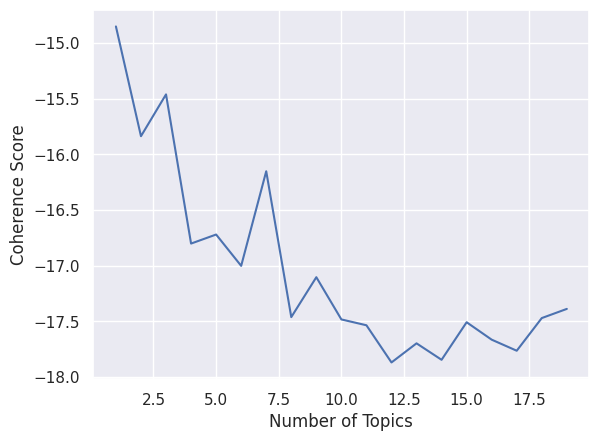

In [ ]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
for x in range(19):
    print(topics[x], score[x])

1 -14.851285518804746
2 -15.837036097493215
3 -15.461609333631493
4 -16.801483358036442
5 -16.72031563835717
6 -17.001703116427944
7 -16.152012107647973
8 -17.46202411892054
9 -17.103651139775806
10 -17.48295631812321
11 -17.535375111826863
12 -17.86932773397113
13 -17.697666374400423
14 -17.845527270542988
15 -17.508202288517353
16 -17.664683947110063
17 -17.764048125226314
18 -17.470708840795318
19 -17.388311541742908


In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = ph['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


Process ForkPoolWorker-104:
Process ForkPoolWorker-101:
Process ForkPoolWorker-102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-103:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: ignored

In [ ]:
for x in range(19):
    print(topics[x], score[x])



1 0.47332881249368464
2 0.42782374398089373
3 0.4735843561052322
4 0.4695128387798202
5 0.45267682781506124
6 0.46964903629276594
7 0.4848820173825059
8 0.4433178609644044
9 0.4821173134415237
10 0.493110415213731
11 0.4943996042499148
12 0.48656523058985707
13 0.508760236242207
14 0.48036478028404606
15 0.48776799400643345
16 0.4837586843363762
17 0.4805822185630093
18 0.49202900579602926
19 0.48949898728116


 c_umass = 3 no lower

In [ ]:
# Optimal model
lda_model_cumass = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=100)

In [ ]:
# lda_model_cumass.save(datapath(f'{dir_actual}lda_model_cumass'))
lda_model_cumass = models.ldamodel.LdaModel.load(datapath(f'{dir_actual}lda_model_cumass'))

In [ ]:
#Print topics
lda_model_cumass.print_topics(-1)

[(0,
  '0.083*"President Ferdinand Marcos" + 0.036*"manila President Ferdinand" + 0.014*"MANILA Philippines President" + 0.014*"Secretary Jesus Crispin" + 0.012*"Department Justice DOJ" + 0.012*"Bureau Immigration BI" + 0.012*"Philippines President Ferdinand" + 0.011*"Armed Forces Philippines" + 0.010*"Jesus Crispin Remulla" + 0.010*"Coast Guard PCG"'),
 (1,
  '0.046*"Philippine National Police" + 0.038*"National Police PNP" + 0.032*"Department Health DOH" + 0.018*"Governor Roel Degamo" + 0.017*"Negros oriental Governor" + 0.016*"oriental Governor Roel" + 0.016*"Commission Elections Comelec" + 0.012*"Department Education DepEd" + 0.010*"Arnolfo Arnie Teves" + 0.010*"Aquino International Airport"'),
 (2,
  '0.043*"Ferdinand Bongbong Marcos" + 0.036*"President Ferdinand Bongbong" + 0.018*"South China Sea" + 0.012*"Atmospheric Geophysical Astronomical" + 0.012*"Philippine Atmospheric Geophysical" + 0.012*"Services Administration PAGASA" + 0.012*"Geophysical Astronomical Services" + 0.012*

In [ ]:
# Where does a text belong to
lda_model_cumass[corpus][0]
ph['Text'][0]

'Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights'

In [ ]:
# Visualize topics
lda_display_cumass = pyLDAvis.gensim_models.prepare(lda_model_cumass, corpus, dictionary)
pyLDAvis.display(lda_display_cumass)

In [ ]:
# Save the report
pyLDAvis.save_html(lda_display_cumass, f'{dir_actual}lda-ph-trigram-cumass.html')

trigram c_v = 13 no lower


In [ ]:
lda_model_cv = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=13, workers = 4, passes=100)

In [ ]:

# lda_model_cv.save(datapath(f'{dir_actual}lda_model_cv'))
lda_model_cv = models.ldamodel.LdaModel.load(datapath(f'{dir_actual}lda_model_cv'))


In [ ]:
#Print topics
lda_model_cv.print_topics(-1)

[(0,
  '0.113*"Ferdinand Bongbong Marcos" + 0.095*"President Ferdinand Bongbong" + 0.032*"Geophysical Astronomical Services" + 0.032*"Astronomical Services Administration" + 0.032*"Atmospheric Geophysical Astronomical" + 0.032*"Services Administration PAGASA" + 0.032*"Philippine Atmospheric Geophysical" + 0.030*"West Philippine Sea" + 0.028*"weather bureau say" + 0.027*"Department Foreign Affairs"'),
 (1,
  '0.120*"Department Health DOH" + 0.026*"Negros Oriental Representative" + 0.025*"Health DOH say" + 0.024*"Oriental Representative Arnolfo" + 0.023*"Representative Arnolfo Arnie" + 0.022*"case active tally" + 0.021*"new case active" + 0.021*"Department Budget Management" + 0.019*"MANILA Philippines Department" + 0.018*"Budget Management DBM"'),
 (2,
  '0.043*"MT Princess Empress" + 0.033*"Department Public Works" + 0.033*"Public Works Highways" + 0.031*"local government unit" + 0.030*"Works Highways DPWH" + 0.023*"oil spill oriental" + 0.023*"spill oriental Mindoro" + 0.019*"governme

In [ ]:
# Where does a text belong to
print(lda_model_cv[corpus][0])
print(ph['Text'][0])

[(0, 0.07692308), (1, 0.07692308), (2, 0.07692308), (3, 0.07692308), (4, 0.07692308), (5, 0.07692308), (6, 0.07692308), (7, 0.07692308), (8, 0.07692308), (9, 0.07692308), (10, 0.07692308), (11, 0.07692308), (12, 0.07692308)]
Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights


In [ ]:
# Visualize topics
lda_display_cv = pyLDAvis.gensim_models.prepare(lda_model_cv, corpus, dictionary)
pyLDAvis.display(lda_display_cv)

In [ ]:
# pyLDAvis.save_html(lda_display_cv, f'{dir_actual}lda-ph-trigram-cv.html')

display load

In [ ]:
from IPython.display import display, HTML

# Path to the uploaded HTML file
html_file_path = f'{dir_actual}lda-ph-index.html'

# Read the HTML file and display it
with open(html_file_path, 'r') as file:
    html_contents = file.read()
    display(HTML(html_contents))

In [ ]:
cv_list = []
for x in range(13):
    l = []
    print(x, lda_model_cv.show_topic(x, topn=10))
    for i in lda_model_cv.show_topic(x, topn=10):
        # print(i[0])
        l.append(i[0])
    cv_list.append(l)


0 [('Ferdinand Bongbong Marcos', 0.11255315), ('President Ferdinand Bongbong', 0.094920106), ('Geophysical Astronomical Services', 0.031837467), ('Astronomical Services Administration', 0.031837467), ('Atmospheric Geophysical Astronomical', 0.031837467), ('Services Administration PAGASA', 0.031837467), ('Philippine Atmospheric Geophysical', 0.031837467), ('West Philippine Sea', 0.02983461), ('weather bureau say', 0.028498849), ('Department Foreign Affairs', 0.0273112)]
1 [('Department Health DOH', 0.11969622), ('Negros Oriental Representative', 0.026036901), ('Health DOH say', 0.024609935), ('Oriental Representative Arnolfo', 0.024184022), ('Representative Arnolfo Arnie', 0.02279434), ('case active tally', 0.021564612), ('new case active', 0.021246603), ('Department Budget Management', 0.021114718), ('MANILA Philippines Department', 0.019197447), ('Budget Management DBM', 0.01775488)]
2 [('MT Princess Empress', 0.04332982), ('Department Public Works', 0.033482123), ('Public Works Highw

In [ ]:
cv_list

[['Ferdinand Bongbong Marcos',
  'President Ferdinand Bongbong',
  'Geophysical Astronomical Services',
  'Astronomical Services Administration',
  'Atmospheric Geophysical Astronomical',
  'Services Administration PAGASA',
  'Philippine Atmospheric Geophysical',
  'West Philippine Sea',
  'weather bureau say',
  'Department Foreign Affairs'],
 ['Department Health DOH',
  'Negros Oriental Representative',
  'Health DOH say',
  'Oriental Representative Arnolfo',
  'Representative Arnolfo Arnie',
  'case active tally',
  'new case active',
  'Department Budget Management',
  'MANILA Philippines Department',
  'Budget Management DBM'],
 ['MT Princess Empress',
  'Department Public Works',
  'Public Works Highways',
  'local government unit',
  'Works Highways DPWH',
  'oil spill oriental',
  'spill oriental Mindoro',
  'government unit lgu',
  'affect oil spill',
  'new EDCA site'],
 ['South China Sea',
  'Philippine Charity Sweepstakes',
  'Charity Sweepstakes Office',
  'Sweepstakes Off

In [ ]:
cumass_list = []
for x in range(3):
    l = []
    print(x, lda_model_cumass.show_topic(x, topn=10))
    for i in lda_model_cumass.show_topic(x, topn=10):
        # print(i[0])
        l.append(i[0])
    cumass_list.append(l)


0 [('President Ferdinand Marcos', 0.08254772), ('manila President Ferdinand', 0.035542753), ('MANILA Philippines President', 0.014429269), ('Secretary Jesus Crispin', 0.013679748), ('Department Justice DOJ', 0.012302338), ('Bureau Immigration BI', 0.012041421), ('Philippines President Ferdinand', 0.012018326), ('Armed Forces Philippines', 0.010578684), ('Jesus Crispin Remulla', 0.010137321), ('Coast Guard PCG', 0.0100660715)]
1 [('Philippine National Police', 0.046398576), ('National Police PNP', 0.037628487), ('Department Health DOH', 0.03189303), ('Governor Roel Degamo', 0.017966319), ('Negros oriental Governor', 0.016584393), ('oriental Governor Roel', 0.016131297), ('Commission Elections Comelec', 0.015866393), ('Department Education DepEd', 0.011595357), ('Arnolfo Arnie Teves', 0.010165195), ('Aquino International Airport', 0.010098015)]
2 [('Ferdinand Bongbong Marcos', 0.04260544), ('President Ferdinand Bongbong', 0.0359477), ('South China Sea', 0.018321246), ('Atmospheric Geophy

In [ ]:
cumass_list

[['President Ferdinand Marcos',
  'manila President Ferdinand',
  'MANILA Philippines President',
  'Secretary Jesus Crispin',
  'Department Justice DOJ',
  'Bureau Immigration BI',
  'Philippines President Ferdinand',
  'Armed Forces Philippines',
  'Jesus Crispin Remulla',
  'Coast Guard PCG'],
 ['Philippine National Police',
  'National Police PNP',
  'Department Health DOH',
  'Governor Roel Degamo',
  'Negros oriental Governor',
  'oriental Governor Roel',
  'Commission Elections Comelec',
  'Department Education DepEd',
  'Arnolfo Arnie Teves',
  'Aquino International Airport'],
 ['Ferdinand Bongbong Marcos',
  'President Ferdinand Bongbong',
  'South China Sea',
  'Atmospheric Geophysical Astronomical',
  'Philippine Atmospheric Geophysical',
  'Services Administration PAGASA',
  'Geophysical Astronomical Services',
  'Astronomical Services Administration',
  'weather bureau say',
  'Social Welfare Development']]

## NER PH

In [ ]:
NER = spacy.load("en_core_web_sm")


In [ ]:
ph_cumass_NER = []

for cluster in cumass_list:
    clusterlist = []

    for ngram in cluster:
        ners = NER(ngram)

        for word in ners.ents:
            # all except date, time, percent, quantity, ordinal and cardinal.
            if word.label_ not in ["DATE", "TIME", "PERCENT", "QUANTITY", "ORDINAL", "CARDINAL"]:
                clusterlist.append((ngram ,word.text, word.label_))

    ph_cumass_NER.append(clusterlist)
    print("=====")  # Move the print statement outside the inner loop


=====
=====
=====


In [ ]:
ph_cumass_NER

[[('President Ferdinand Marcos', 'Ferdinand Marcos', 'PERSON'),
  ('manila President Ferdinand', 'manila', 'GPE'),
  ('manila President Ferdinand', 'Ferdinand', 'GPE'),
  ('MANILA Philippines President', 'MANILA', 'GPE'),
  ('MANILA Philippines President', 'Philippines', 'GPE'),
  ('Secretary Jesus Crispin', 'Jesus Crispin', 'PERSON'),
  ('Bureau Immigration BI', 'Bureau Immigration BI', 'ORG'),
  ('Philippines President Ferdinand', 'Philippines', 'GPE'),
  ('Philippines President Ferdinand', 'Ferdinand', 'GPE'),
  ('Armed Forces Philippines', 'Philippines', 'GPE'),
  ('Jesus Crispin Remulla', 'Jesus Crispin Remulla', 'PERSON'),
  ('Coast Guard PCG', 'Coast Guard', 'ORG')],
 [('Philippine National Police', 'Philippine National Police', 'ORG'),
  ('National Police PNP', 'National Police PNP', 'ORG'),
  ('Department Health DOH', 'Department Health DOH', 'ORG'),
  ('Governor Roel Degamo', 'Roel Degamo', 'PERSON'),
  ('oriental Governor Roel', 'Roel', 'PERSON'),
  ('Aquino International Ai

In [ ]:
with open(f"{dir_actual}ph_NER_cumass_list.txt", "w") as output:
    output.write(str(ph_cumass_NER))


In [ ]:
ph_cv_NER = []

for cluster in cv_list:
    clusterlist = []

    for ngram in cluster:
        ners = NER(ngram)

        for word in ners.ents:
            if word.label_ not in ["DATE", "TIME", "PERCENT", "QUANTITY", "ORDINAL", "CARDINAL"]:
                clusterlist.append((ngram ,word.text, word.label_))

    ph_cv_NER.append(clusterlist)
    print("=====")  # Move the print statement outside the inner loop


=====
=====
=====
=====
=====
=====
=====
=====
=====
=====
=====
=====
=====


In [ ]:
ph_cv_NER

[[('Ferdinand Bongbong Marcos', 'Ferdinand Bongbong Marcos', 'PERSON'),
  ('President Ferdinand Bongbong', 'Ferdinand Bongbong', 'PERSON'),
  ('Astronomical Services Administration',
   'Astronomical Services Administration',
   'ORG'),
  ('Atmospheric Geophysical Astronomical',
   'Atmospheric Geophysical Astronomical',
   'ORG'),
  ('Philippine Atmospheric Geophysical',
   'Philippine Atmospheric Geophysical',
   'ORG'),
  ('West Philippine Sea', 'West Philippine', 'NORP'),
  ('Department Foreign Affairs', 'Department Foreign Affairs', 'ORG')],
 [('Department Health DOH', 'Department Health DOH', 'ORG'),
  ('Negros Oriental Representative', 'Negros Oriental', 'ORG'),
  ('Health DOH say', 'Health DOH', 'ORG'),
  ('Oriental Representative Arnolfo', 'Oriental', 'NORP'),
  ('Oriental Representative Arnolfo', 'Arnolfo', 'GPE'),
  ('Representative Arnolfo Arnie', 'Arnolfo Arnie', 'PERSON'),
  ('Department Budget Management', 'Department Budget Management', 'ORG'),
  ('MANILA Philippines De

In [ ]:
with open(f"{dir_actual}ph_NER_cv_list.txt", "w") as output:
    output.write(str(ph_cv_NER))